### Synthetic Data Regression UMAL vs. Technique Exp.I

In this notebook, it is generated the same synthetic data for a regression problem as it is proposed in UMAL and it is compared with the tecnique of Exp.I 

UMAL is described here:

[***Axel Brando, Jose A. Rodriguez-Serrano, Jordi Vitria, Alberto Rubio. "Modelling heterogeneous distributions with an Uncountable Mixture of Asymmetric Laplacians." Advances in Neural Information Processing Systems. 2019.***](LINK)

UMAL Git Repository:

https://github.com/BBVA/UMAL

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import statistics as stat

%matplotlib inline

### Generate the Synthetic data as UMAL

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import numpy as np

#from umal import build_UMAL, elu_modif, calculate_distribution, log_sum_exp, np_log_sum_exp

lst = []

np.random.seed(41)

size = 1000

points = np.random.beta(0.5,1,8*size//10)*5+0.5

np.random.shuffle(points)
lst += points.tolist()
zones = [[len(lst),'Asymmetric']]

points = 3*np.cos(np.linspace(0,5,num=size))-2
points = points+np.random.normal(scale=np.abs(points)/4,size=size)
lst += points.tolist()
zones += [[len(lst),'Symmetric']]

lst += [np.random.uniform(low=i,high=j) 
        for i,j in zip(np.linspace(-2,-4.5,num=size//2),
                       np.linspace(-0.5,9.,num=size//2))]

zones += [[len(lst),'Uniform']]

points = np.r_[8+np.random.uniform(size=size//2)*0.5,
               1+np.random.uniform(size=size//2)*3.,
             -4.5+np.random.uniform(size=-(-size//2))*1.5]

np.random.shuffle(points)

lst += points.tolist()
zones += [[len(lst),'Multimodal']]

y_train_synthetic = np.array(lst).reshape(-1,1)
x_train_synthetic = np.arange(y_train_synthetic.shape[0]).reshape(-1,1)
x_train_synthetic = x_train_synthetic/x_train_synthetic.max()


disord = np.arange(y_train_synthetic.shape[0])
np.random.shuffle(disord)

x_train_synthetic = x_train_synthetic[disord]
y_train_synthetic = y_train_synthetic[disord]


In [13]:
x = x_train_synthetic
y = y_train_synthetic

In [14]:
x.shape, y.shape

((3800, 1), (3800, 1))

### Plot the data

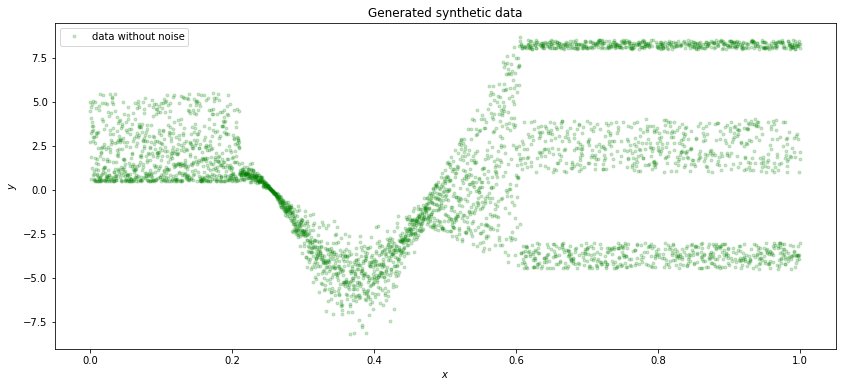

In [15]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Generated synthetic data')

# plot data (with and without noise addition) 
plt.plot(x, y, '.', alpha=0.2, color='green' ) 

plt.legend([r'data without noise',r'data with noise', r'$\mu$', r'$\pm\sigma$'])
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

### Prepare data for training

In [16]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(y.size)
y = np.stack([y[:,0], sigma], axis=1)

In [17]:
x = x.reshape(x[:,0].size, 1)

In [18]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

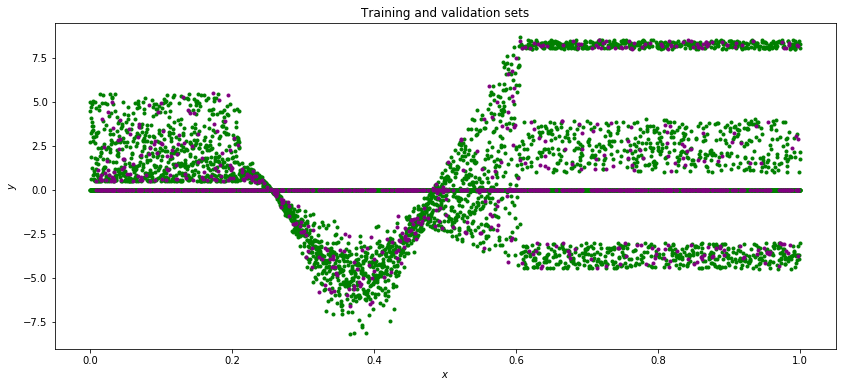

In [19]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Training and validation sets')
plt.plot(x, y, '.', color= 'green')
plt.plot(x_val, y_val, '.', color='purple')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [21]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.cuda.FloatTensor
x_t = Variable(torch.from_numpy(x).type(dtype))
y_t = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [22]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x_t.shape, y_t.shape

(torch.Size([3300, 1]), torch.Size([3300, 2]))

In [28]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model_1 = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           ).cuda()

In [24]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

### Custom loss function

In [26]:
def loss_variance_error(input, target):
    
    # Estimate target value for variance (sigma^2) with (y_pred - y)**2
    #
    #    actual y        is target[:,0]
    # predicted y        is input[:,0]
    #    actual variance is target[:,1] - estimated here
    # predicted variance is input[:,0]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data)**2, 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Training loop

In [29]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model_1(x_t)
    
    # Calculate loss
    loss = loss_variance_error(y_pred, y_t)
    if i%500 == 0: print(f'epoch: {i:4} loss: {loss.data.item():.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0 loss: 3.23e+02
epoch:  500 loss: 3.23e+02
epoch: 1000 loss: 3.23e+02
epoch: 1500 loss: 3.23e+02
epoch: 2000 loss: 3.23e+02
epoch: 2500 loss: 3.23e+02
epoch: 3000 loss: 3.23e+02
epoch: 3500 loss: 3.23e+02
epoch: 4000 loss: 3.23e+02
epoch: 4500 loss: 3.23e+02
epoch: 5000 loss: 3.23e+02
epoch: 5500 loss: 3.23e+02
epoch: 6000 loss: 3.23e+02
epoch: 6500 loss: 3.23e+02
epoch: 7000 loss: 3.23e+02
epoch: 7500 loss: 3.23e+02
epoch: 8000 loss: 3.23e+02
epoch: 8500 loss: 3.23e+02
epoch: 9000 loss: 3.23e+02
epoch: 9500 loss: 3.23e+02


### Get Predictions for validation set

In [30]:
# Get predicted y and sigma for validation set
x_val_t = Variable(torch.from_numpy(x_val).type(dtype)) 
pred_1 = model_1(x_val_t)

# prediction of the response variables
y_pred_1 = pred_1[:,0].cpu().data
sigma_pred_1 = pred_1[:,1].cpu().data

### Plot results

In [33]:
from utilities import validation_metrics

Global model performance: 

- R2 y_hat: 0.0038490045873290635 
- RMSE y_hat: 16.194554913859307 
- RMSE sigma_hat: 13.394444435218086 

Extreme values performance:
 
- Upper bound - 181 Y pts  +sigma 0.25: 

R2 y_hat: -0.2868705466213897
RMSE y_hat: 1.1684053122110138
MAE sigma_hat : 1.243782012768509
-
 Lower bound - 200 Y pts -sigma 0.25: 

R2 y_hat: -0.5245558364529284
RMSE y_hat: 1.1229676935466169
MAE sigma_hat: 1.1867618996987672
-
 In bound - 119 Y pts in [+sigma 0.25,-sigma 0.25]: 

R2 y_hat: -0.1354838630527125
RMSE y_hat: 0.5378897967697122
MAE sigma_hat: 0.7058772758533557


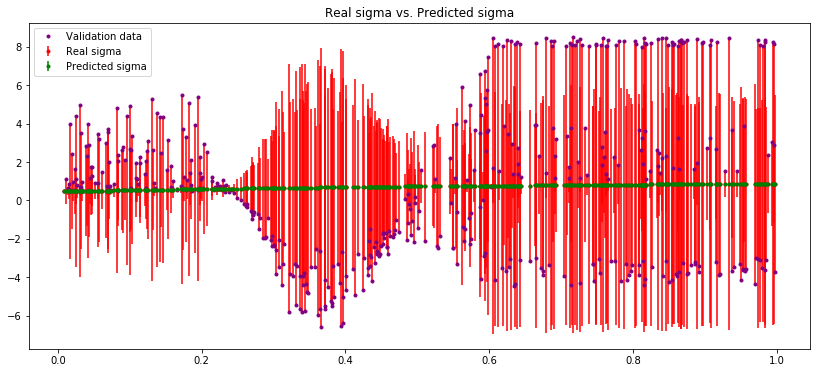

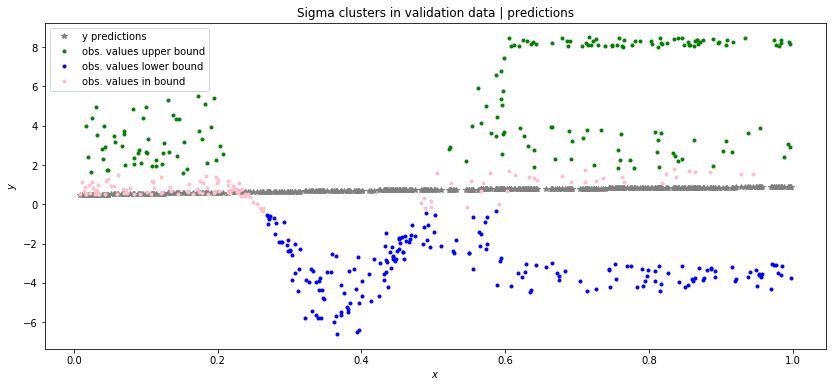

In [35]:
validation_metrics.overall_model_performance(x_val[:,0], y_val[:,0], y_pred_1, sigma_pred_1, std_factor=1/4, extreme_values_performance=True, display_plots=True)